In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27 # figure size in inches

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 30) 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config Completer.use_jedi = False

import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from IPython.display import display


In [2]:
# For ensemble
def get_predictions(model, preds, X_test, algoname):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] # only get probability for 1

    preds[algoname] = {
    'pred': y_pred,
    'pred_proba': y_pred_proba
    }
    
    return preds

In [3]:
def specificity(y_valid, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

# Performance of a dichotomous diagnostic test
def youden_index(y, pred_proba):
    fpr, tpr, thresh = roc_curve(y, pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    return optimal_threshold

# Threshold used
def get_threshold_table(preds):
    thresh = [[algo, val['threshold']] for algo, val in preds.items() if algo != 'y']
    return pd.DataFrame(thresh, columns=['Algo', "Threshold"])

In [4]:
def compute_matrics(predications, days_bin):
    # Calculate probability thresholds
    for algo, preds in predications.items():
        if algo == 'y':
            continue
        threshold = youden_index(predications['y'], preds['pred_proba'])
        preds['threshold'] = threshold
        preds['pred'] = preds['pred_proba'] >= threshold

    # Get threshold to categorize as 1 (CKD)
    threshold = pd.concat([get_threshold_table(preds) for preds in [predications]])
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    display(threshold)

    # Compute matrics
    metrics_list = []

    y_truth = predications['y']
    for algo, preds in predications.items():
        if algo == 'y':
            continue

        y_pred = preds['pred']
        y_pred_proba = preds['pred_proba']

        acc = accuracy_score(y_truth, y_pred)
        f1 = f1_score(y_truth, y_pred)
        prec = precision_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred)
        spec = specificity(y_truth, y_pred)
        roc = roc_auc_score(y_truth, y_pred_proba)

        row = [algo, acc, f1, prec, rec, spec, roc]
        metrics_list.append(row)

    cols = ['Algorithm', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificiy', 'ROC_AUC']
    metrics = pd.DataFrame(metrics_list, columns=cols)
    display(metrics.sort_values('ROC_AUC'))


    # Plot ROC
    fig = plt.figure(figsize=(6,6))
    lw = 2

    rocs = []
    for algo, model in predications.items():
        if algo == 'y':
            continue
        fpr, tpr, thresh = roc_curve(predications['y'], predications[algo]['pred_proba'])
        auc = roc_auc_score(predications['y'], predications[algo]['pred_proba'])
        auc = round(auc, 3)
        rocs.append((algo, auc, [fpr, tpr]))
    # sort legend by AUC
    rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
    for algo, auc, [fpr, tpr] in rocs:    
        plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)

    # chance line
    plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    # plt.title('ROC curve for 6 months', size=12)
    plt.text(0.7,0.3, days_bin, fontsize=12)
    plt.grid(linewidth=1.2, color='lightgray')
    plt.legend(loc='lower right')
    plt.savefig('figures/' + days_bin + '.jpg')

# Load data

In [5]:
df_merged_4_gfr = pd.read_csv('CSV/df_merged_4_gfr.csv')
df_agg_gfr = pd.read_csv('CSV/df_agg_gfr.csv')
df_temporal_gfr = pd.read_csv('CSV/df_temporal_gfr.csv')

# Build models
## Generate result and store in dict
* Set weight to prevent bias, 4 to CKD (1), 1 to non-CKD (0)
* Implement GridSearchCV to find the best parameters

In [6]:
# No need to scale the data as they are all same measurements

def train_model(model, parameters, algoname, X_train, X_test, y_train, preds, months_name):

    print('========================================')
    print('Training %s ' % algoname)
    print()
    
    scores = ['f1']
    
    # retain for loop in case want to try different scores
    for score in scores:

        print("# Tuning hyper-parameters for %s" % score)
        print()

        pipe = Pipeline(steps=[('model', model)])

        search = GridSearchCV(pipe, parameters, n_jobs=-1)
        search.fit(X_train, y_train)
        
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters set found on development set:")
        print()
        print(search.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = search.cv_results_['mean_test_score']
        stds = search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
       
        # Obtained best model
        optimized_model = search.best_estimator_
        
        # Save model
        folder_name = months_name.split('_')[0]
        if 'cat' in months_name:
            joblib.dump(optimized_model, 'models/' + folder_name + '/'+ algoname +'_gfr_cat.joblib')
        else:
            joblib.dump(optimized_model, 'models/' + folder_name + '/'+ algoname +'_gfr.joblib')
        
        # Get predictions
        y_pred = optimized_model.predict(X_test)
        y_pred_proba = optimized_model.predict_proba(X_test)[:,1] # only get probability for 1
        
        preds[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }        
        
        return preds

In [7]:
# Logistic regression
model_lr = LogisticRegression(random_state=0, max_iter=10000, class_weight={0: 1, 1: 4})
parameters_lr = {'model__C': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100,1000, 1e4, 1e5, 1e6]}

# Decision tree
model_dt = DecisionTreeClassifier(random_state=0, class_weight={0: 1, 1: 4}, min_samples_leaf = 30)    
parameters_dt = {'model__max_depth': np.linspace(10, 100, 10)}

# lightGBM
model_lgbm = LGBMClassifier(n_estimators=1000, objective='binary',scale_pos_weight=4)
parameters_lgbm = {'model__learning_rate': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]}

# Random forest
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 4}, n_estimators=800, n_jobs=-1, verbose=1)
parameters_rf = {'model__max_depth': list(range(1,31))}

# Raw GFR

## 180-day bin

In [8]:
df_merged_4_gfr_raw = df_merged_4_gfr[['id', 'days_bin', 'gfr', 'Stage_Progress']]

### 0-179 days (6 months)

In [9]:
df_6 = df_merged_4_gfr_raw[df_merged_4_gfr_raw['days_bin']==1]

X = df_6['gfr'].values.reshape(-1, 1)
y = df_6['Stage_Progress']

# Split train-test data
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_6 = {'y': y_test_6}

preds_6 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_6, X_test_6, y_train_6, preds_6, '6m')
preds_6 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m')
preds_6 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m')
preds_6 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m')

joblib.dump(preds_6, 'predictions/predictions_6m_gfr.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.329 (+/-0.017) for {'model__C': 0.001}
0.329 (+/-0.017) for {'model__C': 0.01}
0.325 (+/-0.020) for {'model__C': 0.1}
0.325 (+/-0.020) for {'model__C': 1}
0.325 (+/-0.020) for {'model__C': 10}
0.325 (+/-0.020) for {'model__C': 100}
0.325 (+/-0.020) for {'model__C': 1000}
0.325 (+/-0.020) for {'model__C': 10000.0}
0.325 (+/-0.020) for {'model__C': 100000.0}
0.325 (+/-0.020) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.467):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.467 (+/-0.122) for {'model__max_depth': 10.0}
0.467 (+/-0.122) for {'model__max_depth': 20.0}
0.467 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.512):

Best parameters set found on development set:

{'model__max_depth': 5}

Grid scores on development set:

0.346 (+/-0.050) for {'model__max_depth': 1}
0.508 (+/-0.114) for {'model__max_depth': 2}
0.483 (+/-0.103) for {'model__max_depth': 3}
0.475 (+/-0.113) for {'model__max_depth': 4}
0.512 (+/-0.162) for {'model__max_depth': 5}
0.496 (+/-0.138) for {'model__max_depth': 6}
0.500 (+/-0.160) for {'model__max_depth': 7}
0.479 (+/-0.177) for {'model__max_depth': 8}
0.467 (+/-0.203) for {'model__max_depth': 9}
0.479 (+/-0.216) for {'model__max_depth': 10}
0.475 (+/-0.200) for {'model__max_depth': 11}
0.471 (+/-0.191) for {'model__max_depth': 12}
0.471 (+/-0.191) for {'model__max_depth': 13}
0.471 (+/-0.191) for {'model__max_depth': 14}
0.471 (+/-0.191) for {'model__max_depth': 15}
0.471 (+/-0.191) for {'model__max_depth': 16}
0.471 (+/-0.191) for {'model__max_depth': 17}
0.471 (+/-0.191) for {'model__max_depth': 18}
0.471 (+/-0.191) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_6m_gfr.joblib']

In [10]:
folder_name = '6m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_6, y_train_6)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_6, y_train_6)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_6, y_train_6)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_6, y_train_6)

# Get predictions
preds_6_ensemble = {'y': y_test_6}
preds_6_ensemble = get_predictions(eclf, preds_6_ensemble, X_test_6, 'VotingClassifier')
preds_6_ensemble = get_predictions(model_stack1, preds_6_ensemble, X_test_6, 'StackingClassifier_logistic')
preds_6_ensemble = get_predictions(model_stack2, preds_6_ensemble,X_test_6, 'StackingClassifier_rf')
preds_6_ensemble = get_predictions(model_stack3, preds_6_ensemble,X_test_6, 'StackingClassifier_lgbm')

joblib.dump(preds_6_ensemble, 'predictions/preds_6_ensemble_gfr.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_6_ensemble_gfr.joblib']

### 180 - 359 days (12 months)

In [11]:
df_12 = df_merged_4_gfr_raw[df_merged_4_gfr_raw['days_bin']==2]

X = df_12['gfr'].values.reshape(-1, 1)
y = df_12['Stage_Progress']

# Split train-test data
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_12 = {'y': y_test_12}

preds_12 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_12, X_test_12, y_train_12, preds_12, '12m')
preds_12 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m')
preds_12 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m')
preds_12 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m')

joblib.dump(preds_12, 'predictions/predictions_12m_gfr.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.328 (+/-0.014) for {'model__C': 1e-05}
0.328 (+/-0.014) for {'model__C': 0.0001}
0.328 (+/-0.014) for {'model__C': 0.001}
0.328 (+/-0.014) for {'model__C': 0.01}
0.328 (+/-0.014) for {'model__C': 0.1}
0.328 (+/-0.014) for {'model__C': 1}
0.328 (+/-0.014) for {'model__C': 10}
0.328 (+/-0.014) for {'model__C': 100}
0.328 (+/-0.014) for {'model__C': 1000}
0.328 (+/-0.014) for {'model__C': 10000.0}
0.328 (+/-0.014) for {'model__C': 100000.0}
0.328 (+/-0.014) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.419):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.419 (+/-0.172) for {'model__max_depth': 10.0}
0.419 (+/-0.172) for {'model__max_depth': 20.0}
0.419 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.7s finished


Best parameter (CV score=0.569):

Best parameters set found on development set:

{'model__max_depth': 12}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 1}
0.393 (+/-0.111) for {'model__max_depth': 2}
0.436 (+/-0.055) for {'model__max_depth': 3}
0.462 (+/-0.102) for {'model__max_depth': 4}
0.483 (+/-0.049) for {'model__max_depth': 5}
0.517 (+/-0.108) for {'model__max_depth': 6}
0.526 (+/-0.096) for {'model__max_depth': 7}
0.547 (+/-0.114) for {'model__max_depth': 8}
0.552 (+/-0.134) for {'model__max_depth': 9}
0.565 (+/-0.162) for {'model__max_depth': 10}
0.565 (+/-0.162) for {'model__max_depth': 11}
0.569 (+/-0.148) for {'model__max_depth': 12}
0.569 (+/-0.148) for {'model__max_depth': 13}
0.569 (+/-0.148) for {'model__max_depth': 14}
0.569 (+/-0.148) for {'model__max_depth': 15}
0.569 (+/-0.148) for {'model__max_depth': 16}
0.569 (+/-0.148) for {'model__max_depth': 17}
0.569 (+/-0.148) for {'model__max_depth': 18}
0.569 (+/-0.148) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_12m_gfr.joblib']

In [12]:
folder_name = '12m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_12, y_train_12)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_12, y_train_12)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_12, y_train_12)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_12, y_train_12)

# Get predictions
preds_12_ensemble = {'y': y_test_12}
preds_12_ensemble = get_predictions(eclf, preds_12_ensemble, X_test_12, 'VotingClassifier')
preds_12_ensemble = get_predictions(model_stack1, preds_12_ensemble, X_test_12, 'StackingClassifier_logistic')
preds_12_ensemble = get_predictions(model_stack2, preds_12_ensemble,X_test_12, 'StackingClassifier_rf')
preds_12_ensemble = get_predictions(model_stack3, preds_12_ensemble,X_test_12, 'StackingClassifier_lgbm')

joblib.dump(preds_12_ensemble, 'predictions/preds_12_ensemble_gfr.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_12_ensemble_gfr.joblib']

### 360 - 539 days (18 months)

In [13]:
df_18 = df_merged_4_gfr_raw[df_merged_4_gfr_raw['days_bin']==3]

X = df_18['gfr'].values.reshape(-1, 1)
y = df_18['Stage_Progress']

# Split train-test data
X_train_18, X_test_18, y_train_18, y_test_18 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_18 = {'y': y_test_18}

preds_18 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_18, X_test_18, y_train_18, preds_18, '18m')
preds_18 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m')
preds_18 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m')
preds_18 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m')

joblib.dump(preds_18, 'predictions/predictions_18m_gfr.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.338):

Best parameters set found on development set:

{'model__C': 0.001}

Grid scores on development set:

0.333 (+/-0.016) for {'model__C': 1e-05}
0.333 (+/-0.016) for {'model__C': 0.0001}
0.338 (+/-0.028) for {'model__C': 0.001}
0.338 (+/-0.028) for {'model__C': 0.01}
0.338 (+/-0.028) for {'model__C': 0.1}
0.338 (+/-0.028) for {'model__C': 1}
0.338 (+/-0.028) for {'model__C': 10}
0.338 (+/-0.028) for {'model__C': 100}
0.338 (+/-0.028) for {'model__C': 1000}
0.338 (+/-0.028) for {'model__C': 10000.0}
0.338 (+/-0.028) for {'model__C': 100000.0}
0.338 (+/-0.028) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.396):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.396 (+/-0.113) for {'model__max_depth': 10.0}
0.396 (+/-0.113) for {'model__max_depth': 20.0}
0.396 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.570):

Best parameters set found on development set:

{'model__max_depth': 9}

Grid scores on development set:

0.333 (+/-0.016) for {'model__max_depth': 1}
0.363 (+/-0.061) for {'model__max_depth': 2}
0.384 (+/-0.109) for {'model__max_depth': 3}
0.473 (+/-0.072) for {'model__max_depth': 4}
0.490 (+/-0.131) for {'model__max_depth': 5}
0.519 (+/-0.075) for {'model__max_depth': 6}
0.570 (+/-0.029) for {'model__max_depth': 7}
0.565 (+/-0.077) for {'model__max_depth': 8}
0.570 (+/-0.099) for {'model__max_depth': 9}
0.570 (+/-0.096) for {'model__max_depth': 10}
0.566 (+/-0.077) for {'model__max_depth': 11}
0.566 (+/-0.077) for {'model__max_depth': 12}
0.566 (+/-0.077) for {'model__max_depth': 13}
0.566 (+/-0.077) for {'model__max_depth': 14}
0.566 (+/-0.077) for {'model__max_depth': 15}
0.566 (+/-0.077) for {'model__max_depth': 16}
0.566 (+/-0.077) for {'model__max_depth': 17}
0.566 (+/-0.077) for {'model__max_depth': 18}
0.566 (+/-0.077) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_18m_gfr.joblib']

In [14]:
folder_name = '18m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_18, y_train_18)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_18, y_train_18)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_18, y_train_18)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_18, y_train_18)

# Get predictions
preds_18_ensemble = {'y': y_test_18}
preds_18_ensemble = get_predictions(eclf, preds_18_ensemble, X_test_18, 'VotingClassifier')
preds_18_ensemble = get_predictions(model_stack1, preds_18_ensemble, X_test_18, 'StackingClassifier_logistic')
preds_18_ensemble = get_predictions(model_stack2, preds_18_ensemble,X_test_18, 'StackingClassifier_rf')
preds_18_ensemble = get_predictions(model_stack3, preds_18_ensemble,X_test_18, 'StackingClassifier_lgbm')

joblib.dump(preds_18_ensemble, 'predictions/preds_18_ensemble_gfr.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_18_ensemble_gfr.joblib']

### 540 - 719 days (24 months)

In [15]:
df_24 = df_merged_4_gfr_raw[df_merged_4_gfr_raw['days_bin']==4]

X = df_24['gfr'].values.reshape(-1, 1)
y = df_24['Stage_Progress']

# Split train-test data
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_24 = {'y': y_test_24}

preds_24 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_24, X_test_24, y_train_24, preds_24, '24m')
preds_24 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m')
preds_24 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m')
preds_24 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m')

joblib.dump(preds_24, 'predictions/predictions_24m_gfr.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.352):

Best parameters set found on development set:

{'model__C': 0.01}

Grid scores on development set:

0.330 (+/-0.017) for {'model__C': 1e-05}
0.335 (+/-0.021) for {'model__C': 0.0001}
0.348 (+/-0.016) for {'model__C': 0.001}
0.352 (+/-0.023) for {'model__C': 0.01}
0.348 (+/-0.023) for {'model__C': 0.1}
0.348 (+/-0.023) for {'model__C': 1}
0.348 (+/-0.023) for {'model__C': 10}
0.348 (+/-0.023) for {'model__C': 100}
0.348 (+/-0.023) for {'model__C': 1000}
0.348 (+/-0.023) for {'model__C': 10000.0}
0.348 (+/-0.023) for {'model__C': 100000.0}
0.348 (+/-0.023) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.468):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.468 (+/-0.120) for {'model__max_depth': 10.0}
0.468 (+/-0.120) for {'model__max_depth': 20.0}
0.468 (

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.643):

Best parameters set found on development set:

{'model__max_depth': 7}

Grid scores on development set:

0.429 (+/-0.251) for {'model__max_depth': 1}
0.541 (+/-0.147) for {'model__max_depth': 2}
0.524 (+/-0.069) for {'model__max_depth': 3}
0.562 (+/-0.084) for {'model__max_depth': 4}
0.583 (+/-0.085) for {'model__max_depth': 5}
0.622 (+/-0.120) for {'model__max_depth': 6}
0.643 (+/-0.100) for {'model__max_depth': 7}
0.617 (+/-0.134) for {'model__max_depth': 8}
0.630 (+/-0.144) for {'model__max_depth': 9}
0.613 (+/-0.129) for {'model__max_depth': 10}
0.609 (+/-0.145) for {'model__max_depth': 11}
0.609 (+/-0.145) for {'model__max_depth': 12}
0.609 (+/-0.145) for {'model__max_depth': 13}
0.609 (+/-0.145) for {'model__max_depth': 14}
0.609 (+/-0.145) for {'model__max_depth': 15}
0.609 (+/-0.145) for {'model__max_depth': 16}
0.609 (+/-0.145) for {'model__max_depth': 17}
0.609 (+/-0.145) for {'model__max_depth': 18}
0.609 (+/-0.145) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_24m_gfr.joblib']

In [16]:
folder_name = '24m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_24, y_train_24)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_24, y_train_24)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_24, y_train_24)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_24, y_train_24)

# Get predictions
preds_24_ensemble = {'y': y_test_24}
preds_24_ensemble = get_predictions(eclf, preds_24_ensemble, X_test_24, 'VotingClassifier')
preds_24_ensemble = get_predictions(model_stack1, preds_24_ensemble, X_test_24, 'StackingClassifier_logistic')
preds_24_ensemble = get_predictions(model_stack2, preds_24_ensemble,X_test_24, 'StackingClassifier_rf')
preds_24_ensemble = get_predictions(model_stack3, preds_24_ensemble,X_test_24, 'StackingClassifier_lgbm')

joblib.dump(preds_24_ensemble, 'predictions/preds_24_ensemble_gfr.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_24_ensemble_gfr.joblib']

## Aggregated

In [17]:
df_agg_gfr_raw = df_agg_gfr[['id', 'gfr', 'Stage_Progress']]

In [18]:
X = df_agg_gfr_raw['gfr'].values.reshape(-1, 1)
y = df_agg_gfr_raw['Stage_Progress']

# Split train-test data
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_agg = {'y': y_test_agg}

preds_agg = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')
preds_agg = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')
preds_agg = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')
preds_agg = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')

joblib.dump(preds_agg, 'predictions/predictions_agg_gfr.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.321 (+/-0.050) for {'model__C': 0.001}
0.321 (+/-0.050) for {'model__C': 0.01}
0.321 (+/-0.050) for {'model__C': 0.1}
0.321 (+/-0.050) for {'model__C': 1}
0.321 (+/-0.050) for {'model__C': 10}
0.321 (+/-0.050) for {'model__C': 100}
0.321 (+/-0.050) for {'model__C': 1000}
0.321 (+/-0.050) for {'model__C': 10000.0}
0.321 (+/-0.050) for {'model__C': 100000.0}
0.321 (+/-0.050) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.504):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.504 (+/-0.185) for {'model__max_depth': 10.0}
0.504 (+/-0.185) for {'model__max_depth': 20.0}
0.504 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.588):

Best parameters set found on development set:

{'model__max_depth': 10}

Grid scores on development set:

0.350 (+/-0.067) for {'model__max_depth': 1}
0.550 (+/-0.120) for {'model__max_depth': 2}
0.575 (+/-0.157) for {'model__max_depth': 3}
0.571 (+/-0.174) for {'model__max_depth': 4}
0.571 (+/-0.172) for {'model__max_depth': 5}
0.575 (+/-0.166) for {'model__max_depth': 6}
0.571 (+/-0.150) for {'model__max_depth': 7}
0.575 (+/-0.107) for {'model__max_depth': 8}
0.583 (+/-0.091) for {'model__max_depth': 9}
0.588 (+/-0.110) for {'model__max_depth': 10}
0.588 (+/-0.096) for {'model__max_depth': 11}
0.588 (+/-0.096) for {'model__max_depth': 12}
0.588 (+/-0.096) for {'model__max_depth': 13}
0.588 (+/-0.096) for {'model__max_depth': 14}
0.588 (+/-0.096) for {'model__max_depth': 15}
0.588 (+/-0.096) for {'model__max_depth': 16}
0.588 (+/-0.096) for {'model__max_depth': 17}
0.588 (+/-0.096) for {'model__max_depth': 18}
0.588 (+/-0.096) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_agg_gfr.joblib']

In [19]:
folder_name = 'agg'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_agg, y_train_agg)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_agg, y_train_agg)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_agg, y_train_agg)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_agg, y_train_agg)

# Get predictions
preds_agg_ensemble = {'y': y_test_agg}
preds_agg_ensemble = get_predictions(eclf, preds_agg_ensemble, X_test_agg, 'VotingClassifier')
preds_agg_ensemble = get_predictions(model_stack1, preds_agg_ensemble, X_test_agg, 'StackingClassifier_logistic')
preds_agg_ensemble = get_predictions(model_stack2, preds_agg_ensemble,X_test_agg, 'StackingClassifier_rf')
preds_agg_ensemble = get_predictions(model_stack3, preds_agg_ensemble,X_test_agg, 'StackingClassifier_lgbm')

joblib.dump(preds_agg_ensemble, 'predictions/preds_agg_ensemble_gfr.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_agg_ensemble_gfr.joblib']

## Temporal

In [20]:
df_temporal_gfr_raw = df_temporal_gfr[['id', 'gfr_1', 'gfr_2', 'gfr_3', 'gfr_4', 'Stage_Progress']]

In [21]:
X = df_temporal_gfr_raw[['gfr_1', 'gfr_2', 'gfr_3', 'gfr_4']]
y = df_temporal_gfr_raw['Stage_Progress']

# Split train-test data
X_train_temporal, X_test_temporal, y_train_temporal, y_test_temporal = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_temporal = {'y': y_test_temporal}

preds_temporal = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')

joblib.dump(preds_temporal, 'predictions/predictions_temporal_gfr.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.337):

Best parameters set found on development set:

{'model__C': 0.001}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.317 (+/-0.049) for {'model__C': 0.0001}
0.337 (+/-0.076) for {'model__C': 0.001}
0.337 (+/-0.076) for {'model__C': 0.01}
0.337 (+/-0.076) for {'model__C': 0.1}
0.337 (+/-0.076) for {'model__C': 1}
0.337 (+/-0.076) for {'model__C': 10}
0.337 (+/-0.076) for {'model__C': 100}
0.337 (+/-0.076) for {'model__C': 1000}
0.337 (+/-0.076) for {'model__C': 10000.0}
0.337 (+/-0.076) for {'model__C': 100000.0}
0.337 (+/-0.076) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.492):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.492 (+/-0.146) for {'model__max_depth': 10.0}
0.492 (+/-0.146) for {'model__max_depth': 20.0}
0.492 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.617):

Best parameters set found on development set:

{'model__max_depth': 5}

Grid scores on development set:

0.337 (+/-0.017) for {'model__max_depth': 1}
0.562 (+/-0.147) for {'model__max_depth': 2}
0.596 (+/-0.111) for {'model__max_depth': 3}
0.604 (+/-0.115) for {'model__max_depth': 4}
0.617 (+/-0.114) for {'model__max_depth': 5}
0.571 (+/-0.148) for {'model__max_depth': 6}
0.567 (+/-0.165) for {'model__max_depth': 7}
0.575 (+/-0.150) for {'model__max_depth': 8}
0.571 (+/-0.166) for {'model__max_depth': 9}
0.579 (+/-0.161) for {'model__max_depth': 10}
0.575 (+/-0.120) for {'model__max_depth': 11}
0.567 (+/-0.135) for {'model__max_depth': 12}
0.562 (+/-0.118) for {'model__max_depth': 13}
0.571 (+/-0.111) for {'model__max_depth': 14}
0.575 (+/-0.155) for {'model__max_depth': 15}
0.571 (+/-0.136) for {'model__max_depth': 16}
0.588 (+/-0.113) for {'model__max_depth': 17}
0.571 (+/-0.146) for {'model__max_depth': 18}
0.587 (+/-0.135) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_temporal_gfr.joblib']

In [22]:
folder_name = 'temporal'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_temporal, y_train_temporal)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)

# Get predictions
preds_temporal_ensemble = {'y': y_test_temporal}
preds_temporal_ensemble = get_predictions(eclf, preds_temporal_ensemble, X_test_temporal, 'VotingClassifier')
preds_temporal_ensemble = get_predictions(model_stack1, preds_temporal_ensemble, X_test_temporal, 'StackingClassifier_logistic')
preds_temporal_ensemble = get_predictions(model_stack2, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_rf')
preds_temporal_ensemble = get_predictions(model_stack3, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_lgbm')

joblib.dump(preds_temporal_ensemble, 'predictions/preds_temporal_ensemble_gfr.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_temporal_ensemble_gfr.joblib']

## Compare models - raw GFR

### 180-day bin

,Algo,Threshold
0,LogisticRegression,0.69658
1,DecisionTreeClassifier,0.75676
2,LGBMClassifier,0.33605
3,RandomForestClassifier,0.58053


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.70000,0.30769,0.66667,0.20000,0.95000,0.47875
1,DecisionTreeClassifier,0.51667,0.43137,0.35484,0.55000,0.50000,0.48000
3,RandomForestClassifier,0.48333,0.49180,0.36585,0.75000,0.35000,0.49062
2,LGBMClassifier,0.46667,0.52941,0.37500,0.90000,0.25000,0.52313


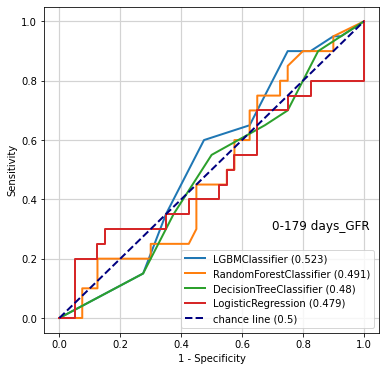

In [23]:
compute_matrics(joblib.load('predictions/predictions_6m_gfr.joblib'), '0-179 days_GFR')

,Algo,Threshold
0,VotingClassifier,0.53326
1,StackingClassifier_logistic,0.36779
2,StackingClassifier_rf,0.70000
3,StackingClassifier_lgbm,0.10728


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.46667,0.50000,0.36364,0.80000,0.30000,0.46875
3,StackingClassifier_lgbm,0.41667,0.52055,0.35849,0.95000,0.15000,0.46875
1,StackingClassifier_logistic,0.53333,0.44000,0.36667,0.55000,0.52500,0.48375
2,StackingClassifier_rf,0.68333,0.29630,0.57143,0.20000,0.92500,0.50500


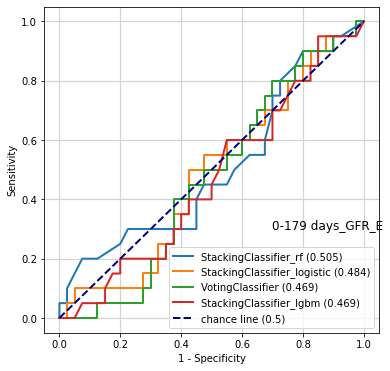

In [24]:
compute_matrics(joblib.load('predictions/preds_6_ensemble_gfr.joblib'), '0-179 days_GFR_E')

,Algo,Threshold
0,LogisticRegression,0.65717
1,DecisionTreeClassifier,0.60215
2,LGBMClassifier,0.33179
3,RandomForestClassifier,0.11076


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,RandomForestClassifier,0.46552,0.52308,0.36957,0.89474,0.25641,0.44399
2,LGBMClassifier,0.60345,0.41026,0.40000,0.42105,0.69231,0.53509
1,DecisionTreeClassifier,0.46552,0.52308,0.36957,0.89474,0.25641,0.56680
0,LogisticRegression,0.58621,0.53846,0.42424,0.73684,0.51282,0.56950


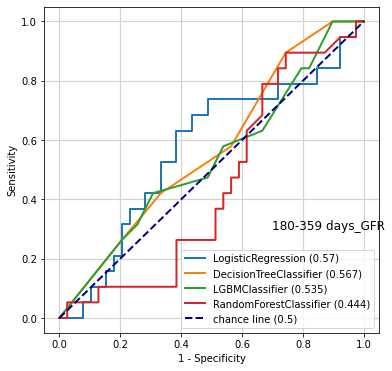

In [25]:
compute_matrics(joblib.load('predictions/predictions_12m_gfr.joblib'), '180-359 days_GFR')

,Algo,Threshold
0,VotingClassifier,0.43499
1,StackingClassifier_logistic,0.28992
2,StackingClassifier_rf,0.35000
3,StackingClassifier_lgbm,0.12196


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.50000,0.53968,0.38636,0.89474,0.30769,0.45344
1,StackingClassifier_logistic,0.41379,0.52778,0.35849,1.00000,0.12821,0.50067
3,StackingClassifier_lgbm,0.46552,0.52308,0.36957,0.89474,0.25641,0.53374
2,StackingClassifier_rf,0.55172,0.51852,0.40000,0.73684,0.46154,0.56343


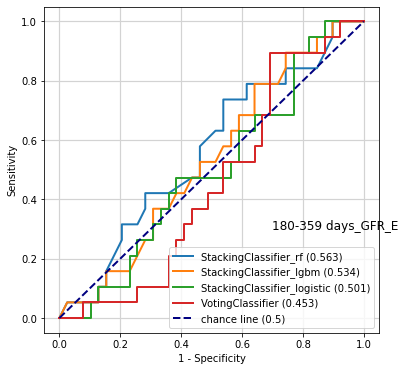

In [26]:
compute_matrics(joblib.load('predictions/preds_12_ensemble_gfr.joblib'), '180-359 days_GFR_E')

,Algo,Threshold
0,LogisticRegression,0.77133
1,DecisionTreeClassifier,0.69841
2,LGBMClassifier,0.33821
3,RandomForestClassifier,0.21285


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.68333,0.24000,0.60000,0.15000,0.95000,0.47750
2,LGBMClassifier,0.61667,0.25806,0.36364,0.20000,0.82500,0.48875
1,DecisionTreeClassifier,0.53333,0.44000,0.36667,0.55000,0.52500,0.51562
3,RandomForestClassifier,0.51667,0.56716,0.40426,0.95000,0.30000,0.53625


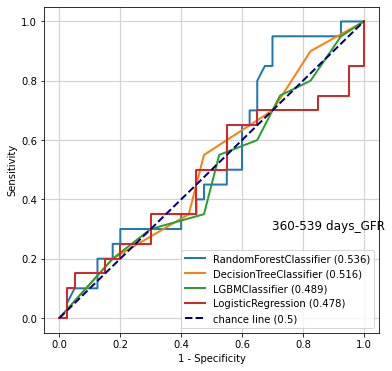

In [27]:
compute_matrics(joblib.load('predictions/predictions_18m_gfr.joblib'), '360-539 days_GFR')

,Algo,Threshold
0,VotingClassifier,0.42899
1,StackingClassifier_logistic,0.30229
2,StackingClassifier_rf,0.38000
3,StackingClassifier_lgbm,0.56782


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,StackingClassifier_logistic,0.46667,0.51515,0.36957,0.85000,0.27500,0.49125
0,VotingClassifier,0.46667,0.51515,0.36957,0.85000,0.27500,0.50875
2,StackingClassifier_rf,0.58333,0.44444,0.40000,0.50000,0.62500,0.51062
3,StackingClassifier_lgbm,0.71667,0.32000,0.80000,0.20000,0.97500,0.54437


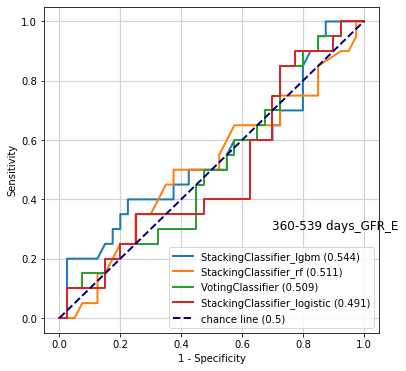

In [28]:
compute_matrics(joblib.load('predictions/preds_18_ensemble_gfr.joblib'), '360-539 days_GFR_E')

,Algo,Threshold
0,LogisticRegression,0.71214
1,DecisionTreeClassifier,0.66667
2,LGBMClassifier,0.33382
3,RandomForestClassifier,0.64183


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.66102,0.50000,0.47619,0.52632,0.72500,0.51711
1,DecisionTreeClassifier,0.59322,0.55556,0.42857,0.78947,0.50000,0.59474
3,RandomForestClassifier,0.71186,0.48485,0.57143,0.42105,0.85000,0.61382
2,LGBMClassifier,0.59322,0.55556,0.42857,0.78947,0.50000,0.63750


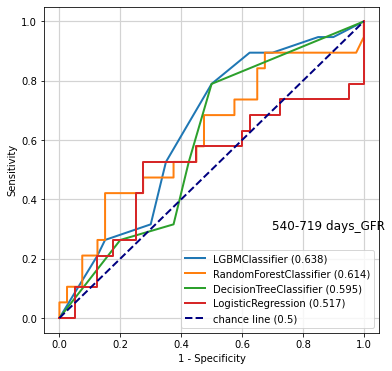

In [29]:
compute_matrics(joblib.load('predictions/predictions_24m_gfr.joblib'), '540-719 days_GFR')

,Algo,Threshold
0,VotingClassifier,0.45368
1,StackingClassifier_logistic,0.30092
2,StackingClassifier_rf,0.24000
3,StackingClassifier_lgbm,0.08516


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,StackingClassifier_lgbm,0.50847,0.55385,0.39130,0.94737,0.30000,0.55658
1,StackingClassifier_logistic,0.57627,0.52830,0.41176,0.73684,0.50000,0.58026
0,VotingClassifier,0.57627,0.54545,0.41667,0.78947,0.47500,0.61053
2,StackingClassifier_rf,0.62712,0.59259,0.45714,0.84211,0.52500,0.62171


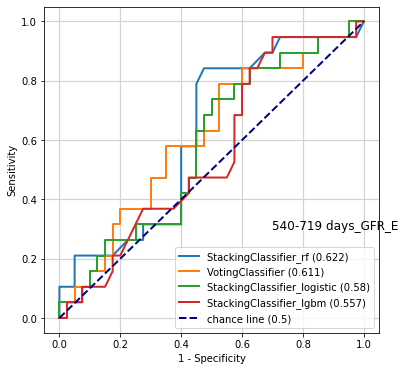

In [30]:
compute_matrics(joblib.load('predictions/preds_24_ensemble_gfr.joblib'), '540-719 days_GFR_E')

### Aggregated

,Algo,Threshold
0,LogisticRegression,0.67831
1,DecisionTreeClassifier,0.72727
2,LGBMClassifier,0.33665
3,RandomForestClassifier,0.12990


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.63333,0.42105,0.44444,0.40000,0.75000,0.51875
3,RandomForestClassifier,0.56667,0.56667,0.42500,0.85000,0.42500,0.58437
2,LGBMClassifier,0.65000,0.58824,0.48387,0.75000,0.60000,0.66000
1,DecisionTreeClassifier,0.65000,0.55319,0.48148,0.65000,0.65000,0.66063


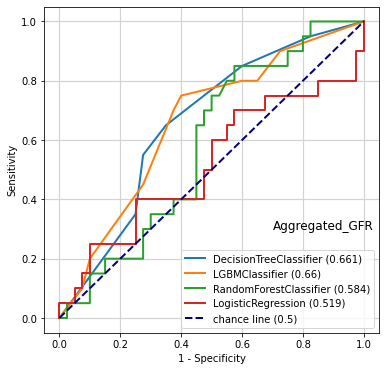

In [31]:
compute_matrics(joblib.load('predictions/predictions_agg_gfr.joblib'), 'Aggregated_GFR')

,Algo,Threshold
0,VotingClassifier,0.44050
1,StackingClassifier_logistic,0.28367
2,StackingClassifier_rf,0.37000
3,StackingClassifier_lgbm,0.34947


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.60000,0.60000,0.45000,0.90000,0.45000,0.61375
2,StackingClassifier_rf,0.61667,0.56604,0.45455,0.75000,0.55000,0.61375
1,StackingClassifier_logistic,0.58333,0.60317,0.44186,0.95000,0.40000,0.65500
3,StackingClassifier_lgbm,0.63333,0.57692,0.46875,0.75000,0.57500,0.65750


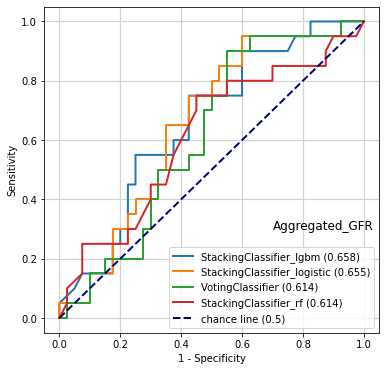

In [32]:
compute_matrics(joblib.load('predictions/preds_agg_ensemble_gfr.joblib'), 'Aggregated_GFR')

### Temporal

,Algo,Threshold
0,LogisticRegression,0.77274
1,DecisionTreeClassifier,0.76712
2,LGBMClassifier,0.33802
3,RandomForestClassifier,0.36172


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.63333,0.38889,0.43750,0.35000,0.77500,0.44625
1,DecisionTreeClassifier,0.51667,0.47273,0.37143,0.65000,0.45000,0.51313
3,RandomForestClassifier,0.55000,0.57143,0.41860,0.90000,0.37500,0.56500
2,LGBMClassifier,0.61667,0.46512,0.43478,0.50000,0.67500,0.57625


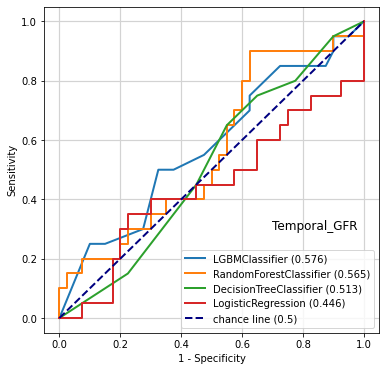

In [33]:
compute_matrics(joblib.load('predictions/predictions_temporal_gfr.joblib'), 'Temporal_GFR')

,Algo,Threshold
0,VotingClassifier,0.59915
1,StackingClassifier_logistic,0.37179
2,StackingClassifier_rf,0.24000
3,StackingClassifier_lgbm,0.15663


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,StackingClassifier_logistic,0.58333,0.46809,0.40741,0.55000,0.60000,0.53250
0,VotingClassifier,0.60000,0.45455,0.41667,0.50000,0.65000,0.53750
2,StackingClassifier_rf,0.63333,0.57692,0.46875,0.75000,0.57500,0.65875
3,StackingClassifier_lgbm,0.61667,0.58182,0.45714,0.80000,0.52500,0.67688


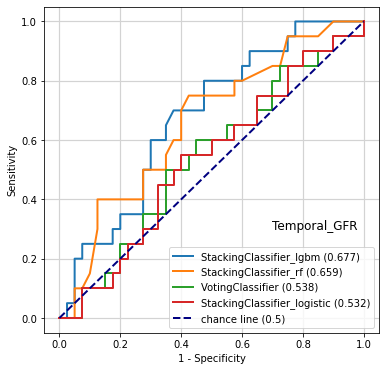

In [34]:
compute_matrics(joblib.load('predictions/preds_temporal_ensemble_gfr.joblib'), 'Temporal_GFR')

# Categorize

## 180-day bin

In [35]:
df_merged_4_gfr_cat = df_merged_4_gfr[['id', 'days_bin', 'gfr_cat', 'Stage_Progress']]

### 0-179 days (6 months)

In [36]:
df_6 = df_merged_4_gfr_cat[df_merged_4_gfr_cat['days_bin']==1]

X = df_6['gfr_cat'].values.reshape(-1, 1)
y = df_6['Stage_Progress']

# Split train-test data
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_6 = {'y': y_test_6}

preds_6 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_6, X_test_6, y_train_6, preds_6, '6m_cat')
preds_6 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m_cat')
preds_6 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m_cat')
preds_6 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_6, X_test_6, y_train_6, preds_6, '6m_cat')

joblib.dump(preds_6, 'predictions/predictions_6m_gfr_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.333 (+/-0.000) for {'model__C': 0.01}
0.333 (+/-0.000) for {'model__C': 0.1}
0.333 (+/-0.000) for {'model__C': 1}
0.333 (+/-0.000) for {'model__C': 10}
0.333 (+/-0.000) for {'model__C': 100}
0.333 (+/-0.000) for {'model__C': 1000}
0.333 (+/-0.000) for {'model__C': 10000.0}
0.333 (+/-0.000) for {'model__C': 100000.0}
0.333 (+/-0.000) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 10.0}
0.333 (+/-0.000) for {'model__max_depth': 20.0}
0.333 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__max_depth': 1}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.333 (+/-0.000) for {'model__max_depth': 2}
0.333 (+/-0.000) for {'model__max_depth': 3}
0.333 (+/-0.000) for {'model__max_depth': 4}
0.333 (+/-0.000) for {'model__max_depth': 5}
0.333 (+/-0.000) for {'model__max_depth': 6}
0.333 (+/-0.000) for {'model__max_depth': 7}
0.333 (+/-0.000) for {'model__max_depth': 8}
0.333 (+/-0.000) for {'model__max_depth': 9}
0.333 (+/-0.000) for {'model__max_depth': 10}
0.333 (+/-0.000) for {'model__max_depth': 11}
0.333 (+/-0.000) for {'model__max_depth': 12}
0.333 (+/-0.000) for {'model__max_depth': 13}
0.333 (+/-0.000) for {'model__max_depth': 14}
0.333 (+/-0.000) for {'model__max_depth': 15}
0.333 (+/-0.000) for {'model__max_depth': 16}
0.333 (+/-0.000) for {'model__max_depth': 17}
0.333 (+/-0.000) for {'model__max_depth': 18}
0.333 (+/-0.000) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_6m_gfr_cat.joblib']

In [37]:
folder_name = '6m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_6, y_train_6)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_6, y_train_6)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_6, y_train_6)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_6, y_train_6)

# Get predictions
preds_6_ensemble = {'y': y_test_6}
preds_6_ensemble = get_predictions(eclf, preds_6_ensemble, X_test_6, 'VotingClassifier')
preds_6_ensemble = get_predictions(model_stack1, preds_6_ensemble, X_test_6, 'StackingClassifier_logistic')
preds_6_ensemble = get_predictions(model_stack2, preds_6_ensemble,X_test_6, 'StackingClassifier_rf')
preds_6_ensemble = get_predictions(model_stack3, preds_6_ensemble,X_test_6, 'StackingClassifier_lgbm')

joblib.dump(preds_6_ensemble, 'predictions/preds_6_ensemble_gfr_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_6_ensemble_gfr_cat.joblib']

### 180 - 359 days (12 months)

In [38]:
df_12 = df_merged_4_gfr_cat[df_merged_4_gfr_cat['days_bin']==2]

X = df_12['gfr_cat'].values.reshape(-1, 1)
y = df_12['Stage_Progress']

# Split train-test data
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_12 = {'y': y_test_12}

preds_12 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_12, X_test_12, y_train_12, preds_12, '12m_cat')
preds_12 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m_cat')
preds_12 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m_cat')
preds_12 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_12, X_test_12, y_train_12, preds_12, '12m_cat')

joblib.dump(preds_12, 'predictions/predictions_12m_gfr_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.328 (+/-0.014) for {'model__C': 1e-05}
0.328 (+/-0.014) for {'model__C': 0.0001}
0.328 (+/-0.014) for {'model__C': 0.001}
0.328 (+/-0.014) for {'model__C': 0.01}
0.328 (+/-0.014) for {'model__C': 0.1}
0.328 (+/-0.014) for {'model__C': 1}
0.328 (+/-0.014) for {'model__C': 10}
0.328 (+/-0.014) for {'model__C': 100}
0.328 (+/-0.014) for {'model__C': 1000}
0.328 (+/-0.014) for {'model__C': 10000.0}
0.328 (+/-0.014) for {'model__C': 100000.0}
0.328 (+/-0.014) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 10.0}
0.328 (+/-0.014) for {'model__max_depth': 20.0}
0.328 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__max_depth': 1}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 1}
0.328 (+/-0.014) for {'model__max_depth': 2}
0.328 (+/-0.014) for {'model__max_depth': 3}
0.328 (+/-0.014) for {'model__max_depth': 4}
0.328 (+/-0.014) for {'model__max_depth': 5}
0.328 (+/-0.014) for {'model__max_depth': 6}
0.328 (+/-0.014) for {'model__max_depth': 7}
0.328 (+/-0.014) for {'model__max_depth': 8}
0.328 (+/-0.014) for {'model__max_depth': 9}
0.328 (+/-0.014) for {'model__max_depth': 10}
0.328 (+/-0.014) for {'model__max_depth': 11}
0.328 (+/-0.014) for {'model__max_depth': 12}
0.328 (+/-0.014) for {'model__max_depth': 13}
0.328 (+/-0.014) for {'model__max_depth': 14}
0.328 (+/-0.014) for {'model__max_depth': 15}
0.328 (+/-0.014) for {'model__max_depth': 16}
0.328 (+/-0.014) for {'model__max_depth': 17}
0.328 (+/-0.014) for {'model__max_depth': 18}
0.328 (+/-0.014) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_12m_gfr_cat.joblib']

In [39]:
folder_name = '12m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_12, y_train_12)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_12, y_train_12)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_12, y_train_12)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_12, y_train_12)

# Get predictions
preds_12_ensemble = {'y': y_test_12}
preds_12_ensemble = get_predictions(eclf, preds_12_ensemble, X_test_12, 'VotingClassifier')
preds_12_ensemble = get_predictions(model_stack1, preds_12_ensemble, X_test_12, 'StackingClassifier_logistic')
preds_12_ensemble = get_predictions(model_stack2, preds_12_ensemble,X_test_12, 'StackingClassifier_rf')
preds_12_ensemble = get_predictions(model_stack3, preds_12_ensemble,X_test_12, 'StackingClassifier_lgbm')

joblib.dump(preds_12_ensemble, 'predictions/preds_12_ensemble_gfr_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_12_ensemble_gfr_cat.joblib']

### 360 - 539 days (18 months)

In [40]:
df_18 = df_merged_4_gfr_cat[df_merged_4_gfr_cat['days_bin']==2]

X = df_18['gfr_cat'].values.reshape(-1, 1)
y = df_18['Stage_Progress']

# Split train-test data
X_train_18, X_test_18, y_train_18, y_test_18 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_18 = {'y': y_test_18}

preds_18 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_18, X_test_18, y_train_18, preds_18, '18m_cat')
preds_18 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m_cat')
preds_18 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m_cat')
preds_18 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_18, X_test_18, y_train_18, preds_18, '18m_cat')

joblib.dump(preds_18, 'predictions/predictions_18m_gfr_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.328 (+/-0.014) for {'model__C': 1e-05}
0.328 (+/-0.014) for {'model__C': 0.0001}
0.328 (+/-0.014) for {'model__C': 0.001}
0.328 (+/-0.014) for {'model__C': 0.01}
0.328 (+/-0.014) for {'model__C': 0.1}
0.328 (+/-0.014) for {'model__C': 1}
0.328 (+/-0.014) for {'model__C': 10}
0.328 (+/-0.014) for {'model__C': 100}
0.328 (+/-0.014) for {'model__C': 1000}
0.328 (+/-0.014) for {'model__C': 10000.0}
0.328 (+/-0.014) for {'model__C': 100000.0}
0.328 (+/-0.014) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 10.0}
0.328 (+/-0.014) for {'model__max_depth': 20.0}
0.328 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__max_depth': 1}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 1}
0.328 (+/-0.014) for {'model__max_depth': 2}
0.328 (+/-0.014) for {'model__max_depth': 3}
0.328 (+/-0.014) for {'model__max_depth': 4}
0.328 (+/-0.014) for {'model__max_depth': 5}
0.328 (+/-0.014) for {'model__max_depth': 6}
0.328 (+/-0.014) for {'model__max_depth': 7}
0.328 (+/-0.014) for {'model__max_depth': 8}
0.328 (+/-0.014) for {'model__max_depth': 9}
0.328 (+/-0.014) for {'model__max_depth': 10}
0.328 (+/-0.014) for {'model__max_depth': 11}
0.328 (+/-0.014) for {'model__max_depth': 12}
0.328 (+/-0.014) for {'model__max_depth': 13}
0.328 (+/-0.014) for {'model__max_depth': 14}
0.328 (+/-0.014) for {'model__max_depth': 15}
0.328 (+/-0.014) for {'model__max_depth': 16}
0.328 (+/-0.014) for {'model__max_depth': 17}
0.328 (+/-0.014) for {'model__max_depth': 18}
0.328 (+/-0.014) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_18m_gfr_cat.joblib']

In [41]:
folder_name = '18m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_18, y_train_18)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_18, y_train_18)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_18, y_train_18)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_18, y_train_18)

# Get predictions
preds_18_ensemble = {'y': y_test_18}
preds_18_ensemble = get_predictions(eclf, preds_18_ensemble, X_test_18, 'VotingClassifier')
preds_18_ensemble = get_predictions(model_stack1, preds_18_ensemble, X_test_18, 'StackingClassifier_logistic')
preds_18_ensemble = get_predictions(model_stack2, preds_18_ensemble,X_test_18, 'StackingClassifier_rf')
preds_18_ensemble = get_predictions(model_stack3, preds_18_ensemble,X_test_18, 'StackingClassifier_lgbm')

joblib.dump(preds_18_ensemble, 'predictions/preds_18_ensemble_gfr_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_18_ensemble_gfr_cat.joblib']

### 540 - 719 days (24 months)

In [42]:
df_24 = df_merged_4_gfr_cat[df_merged_4_gfr_cat['days_bin']==2]

X = df_24['gfr_cat'].values.reshape(-1, 1)
y = df_24['Stage_Progress']

# Split train-test data
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_24 = {'y': y_test_24}

preds_24 = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_24, X_test_24, y_train_24, preds_24, '24m_cat')
preds_24 = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m_cat')
preds_24 = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m_cat')
preds_24 = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_24, X_test_24, y_train_24, preds_24, '24m_cat')

joblib.dump(preds_24, 'predictions/predictions_24m_gfr_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.328 (+/-0.014) for {'model__C': 1e-05}
0.328 (+/-0.014) for {'model__C': 0.0001}
0.328 (+/-0.014) for {'model__C': 0.001}
0.328 (+/-0.014) for {'model__C': 0.01}
0.328 (+/-0.014) for {'model__C': 0.1}
0.328 (+/-0.014) for {'model__C': 1}
0.328 (+/-0.014) for {'model__C': 10}
0.328 (+/-0.014) for {'model__C': 100}
0.328 (+/-0.014) for {'model__C': 1000}
0.328 (+/-0.014) for {'model__C': 10000.0}
0.328 (+/-0.014) for {'model__C': 100000.0}
0.328 (+/-0.014) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 10.0}
0.328 (+/-0.014) for {'model__max_depth': 20.0}
0.328 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.328):

Best parameters set found on development set:

{'model__max_depth': 1}

Grid scores on development set:

0.328 (+/-0.014) for {'model__max_depth': 1}
0.328 (+/-0.014) for {'model__max_depth': 2}
0.328 (+/-0.014) for {'model__max_depth': 3}
0.328 (+/-0.014) for {'model__max_depth': 4}
0.328 (+/-0.014) for {'model__max_depth': 5}
0.328 (+/-0.014) for {'model__max_depth': 6}
0.328 (+/-0.014) for {'model__max_depth': 7}
0.328 (+/-0.014) for {'model__max_depth': 8}
0.328 (+/-0.014) for {'model__max_depth': 9}
0.328 (+/-0.014) for {'model__max_depth': 10}
0.328 (+/-0.014) for {'model__max_depth': 11}
0.328 (+/-0.014) for {'model__max_depth': 12}
0.328 (+/-0.014) for {'model__max_depth': 13}
0.328 (+/-0.014) for {'model__max_depth': 14}
0.328 (+/-0.014) for {'model__max_depth': 15}
0.328 (+/-0.014) for {'model__max_depth': 16}
0.328 (+/-0.014) for {'model__max_depth': 17}
0.328 (+/-0.014) for {'model__max_depth': 18}
0.328 (+/-0.014) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_24m_gfr_cat.joblib']

In [43]:
folder_name = '24m'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_24, y_train_24)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_24, y_train_24)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_24, y_train_24)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_24, y_train_24)

# Get predictions
preds_24_ensemble = {'y': y_test_24}
preds_24_ensemble = get_predictions(eclf, preds_24_ensemble, X_test_24, 'VotingClassifier')
preds_24_ensemble = get_predictions(model_stack1, preds_24_ensemble, X_test_24, 'StackingClassifier_logistic')
preds_24_ensemble = get_predictions(model_stack2, preds_24_ensemble,X_test_24, 'StackingClassifier_rf')
preds_24_ensemble = get_predictions(model_stack3, preds_24_ensemble,X_test_24, 'StackingClassifier_lgbm')

joblib.dump(preds_24_ensemble, 'predictions/preds_24_ensemble_gfr_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_24_ensemble_gfr_cat.joblib']

### Aggregated

In [44]:
df_agg_gfr_cat = df_agg_gfr[['id', 'gfr_cat', 'Stage_Progress']]

In [45]:
X = df_agg_gfr_cat['gfr_cat'].values.reshape(-1, 1)
y = df_agg_gfr_cat['Stage_Progress']

# Split train-test data
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_agg = {'y': y_test_agg}

preds_agg = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg_cat')
preds_agg = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg_cat')
preds_agg = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg_cat')
preds_agg = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg_cat')

joblib.dump(preds_agg, 'predictions/predictions_agg_gfr_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.333 (+/-0.000) for {'model__C': 0.01}
0.333 (+/-0.000) for {'model__C': 0.1}
0.333 (+/-0.000) for {'model__C': 1}
0.333 (+/-0.000) for {'model__C': 10}
0.333 (+/-0.000) for {'model__C': 100}
0.333 (+/-0.000) for {'model__C': 1000}
0.333 (+/-0.000) for {'model__C': 10000.0}
0.333 (+/-0.000) for {'model__C': 100000.0}
0.333 (+/-0.000) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 10.0}
0.333 (+/-0.000) for {'model__max_depth': 20.0}
0.333 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__max_depth': 1}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.333 (+/-0.000) for {'model__max_depth': 2}
0.333 (+/-0.000) for {'model__max_depth': 3}
0.333 (+/-0.000) for {'model__max_depth': 4}
0.333 (+/-0.000) for {'model__max_depth': 5}
0.333 (+/-0.000) for {'model__max_depth': 6}
0.333 (+/-0.000) for {'model__max_depth': 7}
0.333 (+/-0.000) for {'model__max_depth': 8}
0.333 (+/-0.000) for {'model__max_depth': 9}
0.333 (+/-0.000) for {'model__max_depth': 10}
0.333 (+/-0.000) for {'model__max_depth': 11}
0.333 (+/-0.000) for {'model__max_depth': 12}
0.333 (+/-0.000) for {'model__max_depth': 13}
0.333 (+/-0.000) for {'model__max_depth': 14}
0.333 (+/-0.000) for {'model__max_depth': 15}
0.333 (+/-0.000) for {'model__max_depth': 16}
0.333 (+/-0.000) for {'model__max_depth': 17}
0.333 (+/-0.000) for {'model__max_depth': 18}
0.333 (+/-0.000) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_agg_gfr_cat.joblib']

In [46]:
folder_name = 'agg'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_agg, y_train_agg)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_agg, y_train_agg)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_agg, y_train_agg)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_agg, y_train_agg)

# Get predictions
preds_agg_ensemble = {'y': y_test_agg}
preds_agg_ensemble = get_predictions(eclf, preds_agg_ensemble, X_test_agg, 'VotingClassifier')
preds_agg_ensemble = get_predictions(model_stack1, preds_agg_ensemble, X_test_agg, 'StackingClassifier_logistic')
preds_agg_ensemble = get_predictions(model_stack2, preds_agg_ensemble,X_test_agg, 'StackingClassifier_rf')
preds_agg_ensemble = get_predictions(model_stack3, preds_agg_ensemble,X_test_agg, 'StackingClassifier_lgbm')

joblib.dump(preds_agg_ensemble, 'predictions/preds_agg_ensemble_gfr_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_agg_ensemble_gfr_cat.joblib']

### Temporal

In [47]:
df_temporal_gfr_cat = df_temporal_gfr[['id', 'gfr_cat_1', 'gfr_cat_2', 'gfr_cat_3', 'gfr_cat_4', 'Stage_Progress']]

In [48]:
X = df_temporal_gfr_cat[['gfr_cat_1', 'gfr_cat_2', 'gfr_cat_3', 'gfr_cat_4']]
y = df_temporal_gfr_cat['Stage_Progress']

# Split train-test data
X_train_temporal, X_test_temporal, y_train_temporal, y_test_temporal = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_temporal = {'y': y_test_temporal}

preds_temporal = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal_cat')
preds_temporal = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal_cat')
preds_temporal = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal_cat')
preds_temporal = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal_cat')

joblib.dump(preds_temporal, 'predictions/predictions_temporal_gfr_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__C': 1e-05}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.333 (+/-0.000) for {'model__C': 0.01}
0.333 (+/-0.000) for {'model__C': 0.1}
0.329 (+/-0.017) for {'model__C': 1}
0.329 (+/-0.017) for {'model__C': 10}
0.329 (+/-0.017) for {'model__C': 100}
0.329 (+/-0.017) for {'model__C': 1000}
0.329 (+/-0.017) for {'model__C': 10000.0}
0.329 (+/-0.017) for {'model__C': 100000.0}
0.329 (+/-0.017) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.333):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 10.0}
0.333 (+/-0.000) for {'model__max_depth': 20.0}
0.333 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.379):

Best parameters set found on development set:

{'model__max_depth': 9}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.333 (+/-0.000) for {'model__max_depth': 2}
0.342 (+/-0.042) for {'model__max_depth': 3}
0.375 (+/-0.053) for {'model__max_depth': 4}
0.367 (+/-0.068) for {'model__max_depth': 5}
0.375 (+/-0.053) for {'model__max_depth': 6}
0.375 (+/-0.053) for {'model__max_depth': 7}
0.367 (+/-0.068) for {'model__max_depth': 8}
0.379 (+/-0.041) for {'model__max_depth': 9}
0.367 (+/-0.068) for {'model__max_depth': 10}
0.379 (+/-0.041) for {'model__max_depth': 11}
0.362 (+/-0.073) for {'model__max_depth': 12}
0.362 (+/-0.073) for {'model__max_depth': 13}
0.362 (+/-0.073) for {'model__max_depth': 14}
0.362 (+/-0.073) for {'model__max_depth': 15}
0.362 (+/-0.073) for {'model__max_depth': 16}
0.375 (+/-0.053) for {'model__max_depth': 17}
0.375 (+/-0.053) for {'model__max_depth': 18}
0.379 (+/-0.041) for {'model__max_depth': 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_temporal_gfr_cat.joblib']

In [49]:
folder_name = 'temporal'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_gfr_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_gfr_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_gfr_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_gfr_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_temporal, y_train_temporal)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)

# Get predictions
preds_temporal_ensemble = {'y': y_test_temporal}
preds_temporal_ensemble = get_predictions(eclf, preds_temporal_ensemble, X_test_temporal, 'VotingClassifier')
preds_temporal_ensemble = get_predictions(model_stack1, preds_temporal_ensemble, X_test_temporal, 'StackingClassifier_logistic')
preds_temporal_ensemble = get_predictions(model_stack2, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_rf')
preds_temporal_ensemble = get_predictions(model_stack3, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_lgbm')

joblib.dump(preds_temporal_ensemble, 'predictions/preds_temporal_ensemble_gfr_cat.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_temporal_ensemble_gfr_cat.joblib']

## Compare models - categorized GFR

### 180-day bin

,Algo,Threshold
0,LogisticRegression,1.66670
1,DecisionTreeClassifier,1.80982
2,LGBMClassifier,1.33807
3,RandomForestClassifier,1.80733


C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
1,DecisionTreeClassifier,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
2,LGBMClassifier,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
3,RandomForestClassifier,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500


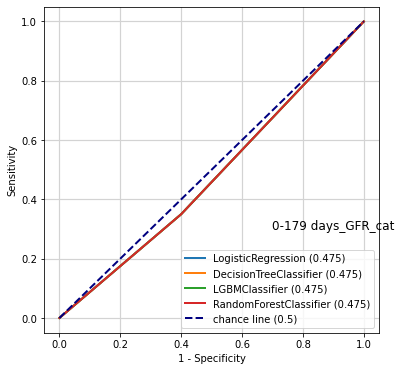

In [50]:
compute_matrics(joblib.load('predictions/predictions_6m_gfr_cat.joblib'), '0-179 days_GFR_cat')

,Algo,Threshold
0,VotingClassifier,1.65557
1,StackingClassifier_logistic,1.42283
2,StackingClassifier_rf,1.52493
3,StackingClassifier_lgbm,1.49076


C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
1,StackingClassifier_logistic,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
2,StackingClassifier_rf,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
3,StackingClassifier_lgbm,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500


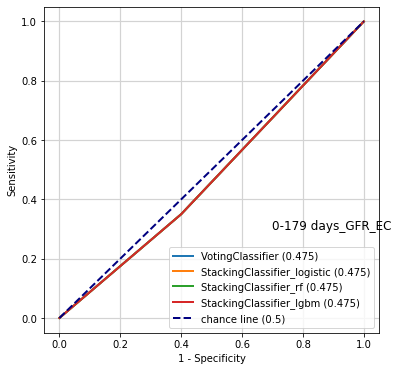

In [51]:
compute_matrics(joblib.load('predictions/preds_6_ensemble_gfr_cat.joblib'), '0-179 days_GFR_EC')

,Algo,Threshold
0,LogisticRegression,0.66089
1,DecisionTreeClassifier,0.75676
2,LGBMClassifier,0.33186
3,RandomForestClassifier,0.75393


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
1,DecisionTreeClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
2,LGBMClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
3,RandomForestClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318


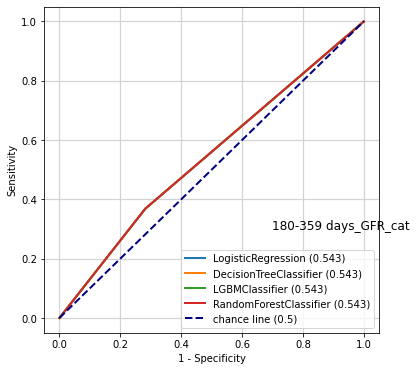

In [52]:
compute_matrics(joblib.load('predictions/predictions_12m_gfr_cat.joblib'), '180-359 days_GFR_cat')

,Algo,Threshold
0,VotingClassifier,0.62612
1,StackingClassifier_logistic,0.35867
2,StackingClassifier_rf,0.43221
3,StackingClassifier_lgbm,0.45510


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
1,StackingClassifier_logistic,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
2,StackingClassifier_rf,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
3,StackingClassifier_lgbm,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318


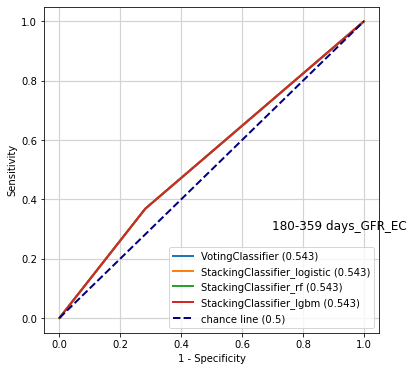

In [53]:
compute_matrics(joblib.load('predictions/preds_12_ensemble_gfr_cat.joblib'), '180-359 days_GFR_EC')

,Algo,Threshold
0,LogisticRegression,0.66089
1,DecisionTreeClassifier,0.75676
2,LGBMClassifier,0.33186
3,RandomForestClassifier,0.75506


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
1,DecisionTreeClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
2,LGBMClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
3,RandomForestClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318


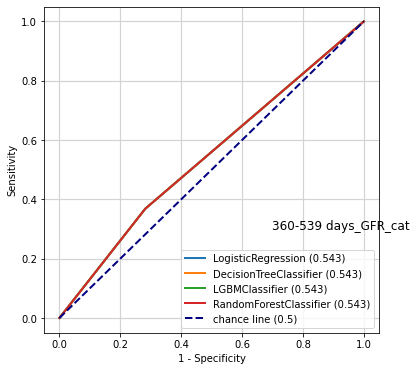

In [54]:
compute_matrics(joblib.load('predictions/predictions_18m_gfr_cat.joblib'), '360-539 days_GFR_cat')

,Algo,Threshold
0,VotingClassifier,0.62556
1,StackingClassifier_logistic,0.35902
2,StackingClassifier_rf,0.42910
3,StackingClassifier_lgbm,0.45468


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
1,StackingClassifier_logistic,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
2,StackingClassifier_rf,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
3,StackingClassifier_lgbm,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318


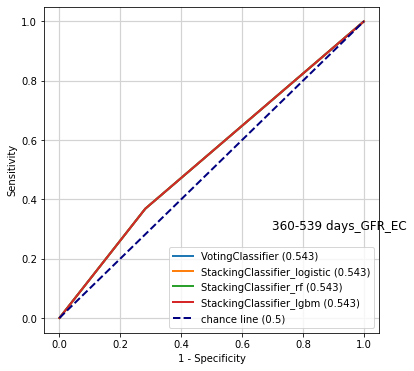

In [55]:
compute_matrics(joblib.load('predictions/preds_18_ensemble_gfr_cat.joblib'), '360-539 days_GFR_EC')

,Algo,Threshold
0,LogisticRegression,0.66089
1,DecisionTreeClassifier,0.75676
2,LGBMClassifier,0.33186
3,RandomForestClassifier,0.75457


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
1,DecisionTreeClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
2,LGBMClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
3,RandomForestClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318


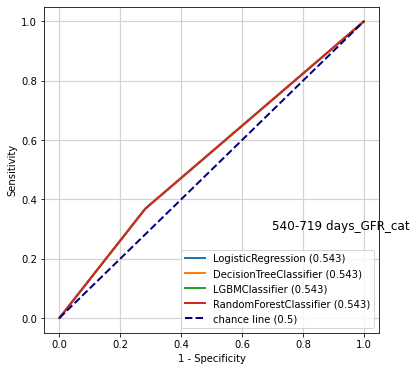

In [56]:
compute_matrics(joblib.load('predictions/predictions_24m_gfr_cat.joblib'), '540-719 days_GFR_cat')

,Algo,Threshold
0,VotingClassifier,0.62633
1,StackingClassifier_logistic,0.35878
2,StackingClassifier_rf,0.44968
3,StackingClassifier_lgbm,0.45447


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
1,StackingClassifier_logistic,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
2,StackingClassifier_rf,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318
3,StackingClassifier_lgbm,0.60345,0.37838,0.38889,0.36842,0.71795,0.54318


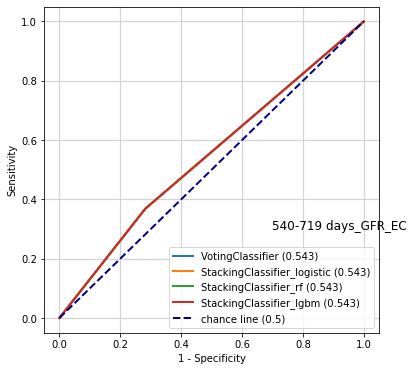

In [57]:
compute_matrics(joblib.load('predictions/preds_24_ensemble_gfr_cat.joblib'), '540-719 days_GFR_EC')

### Aggregated

,Algo,Threshold
0,LogisticRegression,0.66670
1,DecisionTreeClassifier,0.83333
2,LGBMClassifier,0.33831
3,RandomForestClassifier,0.83191


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,LogisticRegression,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000
1,DecisionTreeClassifier,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000
2,LGBMClassifier,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000
3,RandomForestClassifier,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000


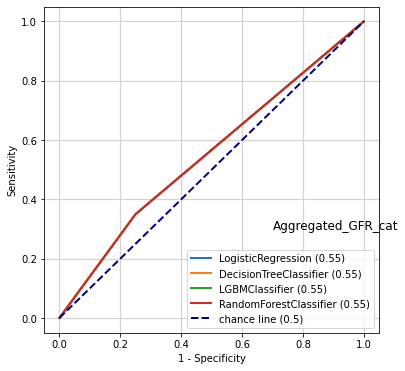

In [58]:
compute_matrics(joblib.load('predictions/predictions_agg_gfr_cat.joblib'), 'Aggregated_GFR_cat')

,Algo,Threshold
0,VotingClassifier,0.66686
1,StackingClassifier_logistic,0.44283
2,StackingClassifier_rf,0.54634
3,StackingClassifier_lgbm,0.45119


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
0,VotingClassifier,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000
1,StackingClassifier_logistic,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000
2,StackingClassifier_rf,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000
3,StackingClassifier_lgbm,0.61667,0.37838,0.41176,0.35000,0.75000,0.55000


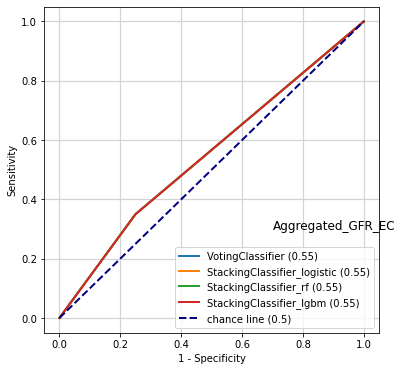

In [59]:
compute_matrics(joblib.load('predictions/preds_agg_ensemble_gfr_cat.joblib'), 'Aggregated_GFR_EC')

### Temporal

,Algo,Threshold
0,LogisticRegression,0.66669
1,DecisionTreeClassifier,1.80982
2,LGBMClassifier,0.33780
3,RandomForestClassifier,0.75385


C:\Users\SC-SG\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,DecisionTreeClassifier,0.66667,0.00000,0.00000,0.00000,1.00000,0.47500
0,LogisticRegression,0.56667,0.38095,0.36364,0.40000,0.65000,0.49000
3,RandomForestClassifier,0.58333,0.39024,0.38095,0.40000,0.67500,0.50500
2,LGBMClassifier,0.55000,0.42553,0.37037,0.50000,0.57500,0.51125


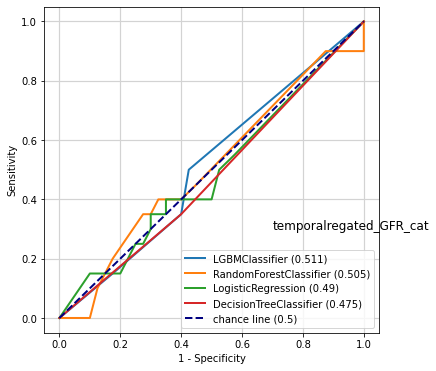

In [60]:
compute_matrics(joblib.load('predictions/predictions_temporal_gfr_cat.joblib'), 'temporalregated_GFR_cat')

,Algo,Threshold
0,VotingClassifier,0.47731
1,StackingClassifier_logistic,0.29271
2,StackingClassifier_rf,0.46624
3,StackingClassifier_lgbm,0.36441


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,StackingClassifier_logistic,0.36667,0.50000,0.33929,0.95000,0.07500,0.47250
0,VotingClassifier,0.36667,0.50000,0.33929,0.95000,0.07500,0.47375
3,StackingClassifier_lgbm,0.60000,0.45455,0.41667,0.50000,0.65000,0.56812
2,StackingClassifier_rf,0.63333,0.47619,0.45455,0.50000,0.70000,0.60375


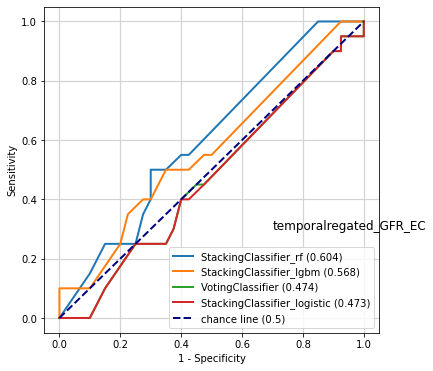

In [61]:
compute_matrics(joblib.load('predictions/preds_temporal_ensemble_gfr_cat.joblib'), 'temporalregated_GFR_EC')